# Runtime Analysis
This notebook is designed to compare output from two ACCESS-OM2 simulations - an existing reference case and a new underway simulation. The idea is to compare the two simulations over time slices which are comparable.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:34523 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [4]:
db='/home/157/amh157/CC_sandbox/RYF9091.db'
session = cc.database.create_session(db)

In [5]:
RunDirectory = '/g/data3/hh5/tmp/cosima/access-om2-01/'
ReferenceExpt = '01deg_jra55v13_ryf8485_spinup6_000-413'
UnderwayExpt = '01deg_jra55v13_ryf9091'
ReferenceName = 'RYF8485'
UnderwayName = 'RYF9091'

**This is the reference run** - shouldn't need updating.

In [5]:
cc.database.build_index(RunDirectory+ReferenceExpt,session,update=True)

Indexing experiment: 01deg_jra55v13_ryf8485_spinup6_000-413


100%|██████████| 6079/6079 [12:29<00:00,  5.87it/s]


6079

**This is the underway run** - update when needed.

In [6]:
cc.database.build_index(RunDirectory+UnderwayExpt,session,update=True)

Indexing experiment: 01deg_jra55v13_ryf9091


100%|██████████| 153/153 [00:28<00:00,  4.82it/s]


153

## Timeseries

### Global Average Temperature

Text(0.5,1,'temp_global_ave')

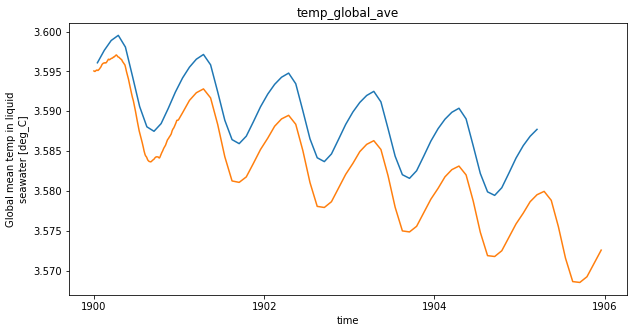

In [24]:
variable = 'temp_global_ave'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(label=UnderwayName)
end_year = (cftime.date2num(temp_und.time[-1],units='days since 0001-01-01')/365).astype(int) - 1899 
end_time = '%04d-12-31' % end_year
temp = cc.querying.getvar(ReferenceExpt,variable,session,end_time=end_time,offset=693135)
temp.plot(label=ReferenceName)
plt.title(variable)

### Global Average Salinity

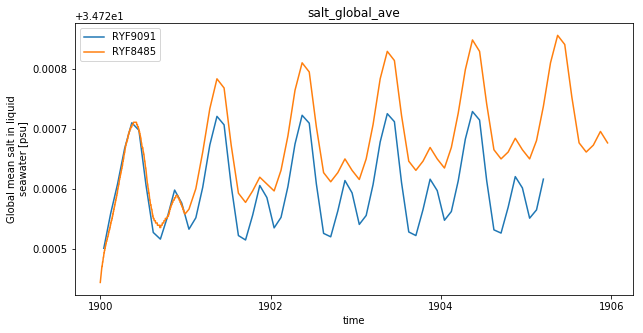

In [25]:
variable = 'salt_global_ave'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(label=UnderwayName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,offset=693135,end_time=end_time)
temp.plot(label=ReferenceName)
plt.title(variable)
plt.legend()

### Surface Temperature

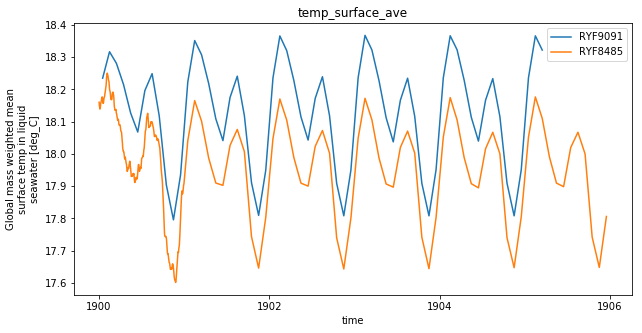

In [26]:
variable = 'temp_surface_ave'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(label=UnderwayName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,offset=693135,end_time=end_time)
temp.plot(label=ReferenceName)
plt.title(variable)
plt.legend()

### Surface Salinity

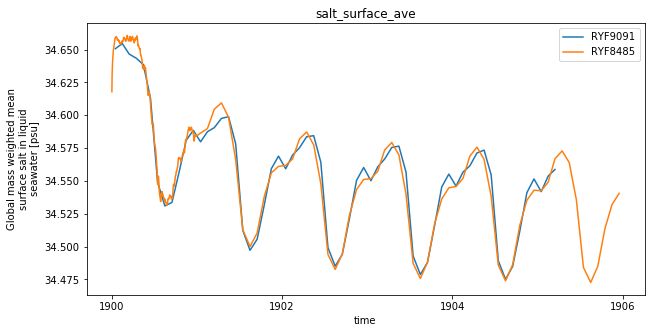

In [27]:
variable = 'salt_surface_ave'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(label=UnderwayName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,offset=693135,end_time=end_time)
temp.plot(label=ReferenceName)
plt.title(variable)
plt.legend()

### Total Kinetic Energy

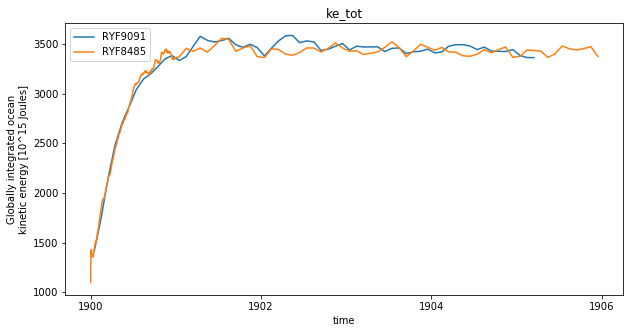

In [28]:
variable = 'ke_tot'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(label=UnderwayName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,offset=693135,end_time=end_time)
temp.plot(label=ReferenceName)
plt.title(variable)
plt.legend()

### Drake Passage Transport

Text(0.5,1,'ACC Transport')

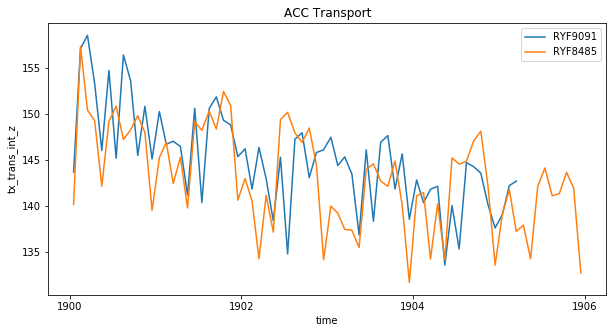

In [20]:
xmin=-69.9
ymin=-71.6
ymax=-51.0

plt.figure(figsize=(10,5))

tx_trans = cc.querying.getvar(UnderwayExpt,'tx_trans_int_z',session)
DP_und = tx_trans.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
DP_und.plot(label=UnderwayName)

tx_trans = cc.querying.getvar(ReferenceExpt,'tx_trans_int_z',session,offset=693135,end_time = end_time)
DP_ref = tx_trans.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
DP_ref.plot(label=ReferenceName)


plt.legend()
plt.title("ACC Transport")

### Ross Sea Salinity @ 350m depth

Text(0.5,1,'Salinity in SW Ross Sea')

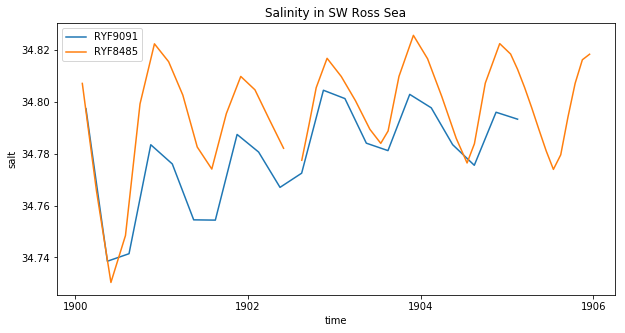

In [21]:
plt.figure(figsize=(10,5))
zlevel = 350
salt = cc.querying.getvar(UnderwayExpt,'salt',session).sel(st_ocean = zlevel,method='nearest')
salt = salt.sel(yt_ocean=slice(-78,-74)).sel(xt_ocean=slice(-195,-190)).mean('yt_ocean').mean('xt_ocean')
salt.plot(label=UnderwayName)
salt = cc.querying.getvar(ReferenceExpt,'salt',session,offset=693135,end_time = end_time).sel(st_ocean = zlevel,method='nearest')
salt = salt.sel(yt_ocean=slice(-78,-74)).sel(xt_ocean=slice(-195,-190)).mean('yt_ocean').mean('xt_ocean')
salt.plot(label=ReferenceName)
plt.legend()
plt.title('Salinity in SW Ross Sea')

### AABW overturning circulation @ 40°S

Text(0.5,1,'AABW Cell')

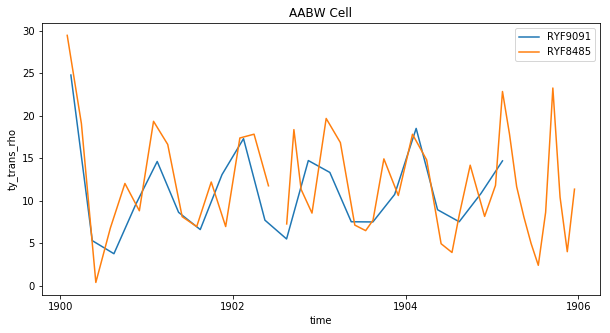

In [22]:
latitude=-40
plt.figure(figsize=(10,5))
psi = cc.querying.getvar(UnderwayExpt, 'ty_trans_rho',session)
psi_aabw = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
psi_aabw_sum.plot(label=UnderwayName)
psi = cc.querying.getvar(ReferenceExpt, 'ty_trans_rho',session,offset=693135,end_time = end_time)
psi_aabw = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
psi_aabw_sum.plot(label=ReferenceName)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

Text(0.5,1,'AMOC Cell')

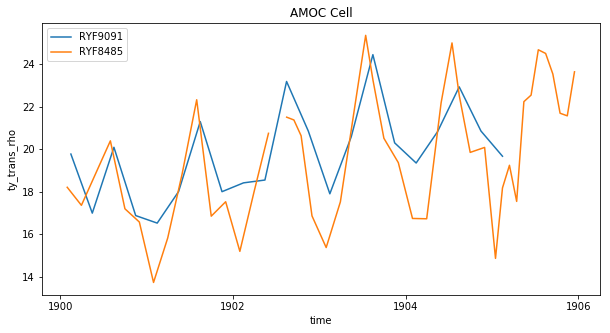

In [23]:
plt.figure(figsize=(10,5))
psi = cc.querying.getvar(UnderwayExpt, 'ty_trans_rho',session)
psi_amoc = psi.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
psi_amoc_und = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
psi_amoc_und = psi_amoc_und.sel(potrho=slice(1035.5,None)).max('potrho')
psi_amoc_und.plot(label=UnderwayName)
psi = cc.querying.getvar(ReferenceExpt, 'ty_trans_rho',session,offset=693135,end_time = end_time)
psi_amoc = psi.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
psi_amoc_ref = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
psi_amoc_ref = psi_amoc_ref.sel(potrho=slice(1035.5,None)).max('potrho')
psi_amoc_ref.plot(label=ReferenceName)
plt.legend()
plt.title('AMOC Cell')